In [112]:
from functools import partial
import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from lightning import Trainer
from lightning.pytorch import seed_everything
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from lightning_uq_box.datamodules import UCIRegressionDatamodule
from lightning_uq_box.datasets import UCIConcrete, UCIEnergy, UCIYacht
from lightning_uq_box.models import MLP
from lightning_uq_box.uq_methods import MVERegression, DeepEnsembleRegression
import scienceplots
import cmcrameri

import sys
sys.path.append("../../")
from uq import GaussianUQMeasure

In [6]:
root = "../../data/uci/"
experiment = "yacht"
ckpt_path = "../../results/robustness/checkpoints/"

In [32]:
ensembles = 25
distortion = [0,0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 5.0]

In [33]:
dm = UCIRegressionDatamodule(dataset_name = experiment, root = root, train_distortion=0, train_size = 0.9, batch_size=1000)
sample = next(iter(dm.train_dataloader()))
n_input = sample["input"].shape[-1]
trainer = Trainer()

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [34]:
mlp = MLP(n_inputs = n_input, n_outputs = 2, activation_fn=nn.ReLU(), n_hidden = [256, 512, 1024])
model = MVERegression(
        mlp, optimizer=partial(torch.optim.Adam, lr=1e-2), burnin_epochs=20
    )

In [41]:
base_ensemble = [{"base_model": model, "ckpt_path": f"{ckpt_path}/{experiment}/{experiment}_{x}.ckpt"} for x in range(ensembles)]
robustness_members = [{"base_model": model, "ckpt_path": f"{ckpt_path}/{experiment}/{experiment}_distorted_{x}.ckpt"} for x in distortion]

In [42]:
# Base prediction
base_ensemble.append(robustness_members[1])
deep_ens_nll = DeepEnsembleRegression(base_ensemble)
input = next(iter(dm.train_dataloader()))
base_pred = deep_ens_nll.predict_step(input["input"])["samples"].detach()
log_sigma_2 = base_pred[:,1]
eps = torch.ones_like(log_sigma_2) * 1e-6
base_pred[:,1] = torch.sqrt(eps + np.exp(log_sigma_2))

In [43]:
mu = base_pred[:,0,:]
sigma = base_pred[:,1,:]
sample_pred = torch.distributions.normal.Normal(mu, sigma).sample((40,)).swapaxes(0,1).flatten(start_dim = 1)
sample_pred.shape

torch.Size([276, 1040])

In [44]:
sigma[:,-1].mean()

tensor(0.0111)

In [ ]:
# 1 - 0.24 5 - 1.9 0.1 - 0.01

In [86]:
def median_heuristic_gamma(x: torch.Tensor) -> torch.Tensor:
    """
    Computes the gamma parameter for a Gaussian kernel using the median heuristic.
    
    Args:
        x (torch.Tensor): Input tensor of shape (B, M) where B is batch size and 
                          M are samples from a 1D standardized distribution.
                          
    Returns:
        torch.Tensor: Gamma values of shape (B,), one per batch.
    """
    B, M = x.shape
    
    # Expand dimensions for pairwise distance computation
    x1 = x.unsqueeze(2)  # (B, M, 1)
    x2 = x.unsqueeze(1)  # (B, 1, M)
    
    # Compute pairwise squared distances
    dists = (x1 - x2) ** 2  # (B, M, M)
    
    # Flatten upper triangular part (excluding diagonal)
    triu_indices = torch.triu_indices(M, M, offset=1)
    dists_flat = dists[:, triu_indices[0], triu_indices[1]]  # (B, M*(M-1)/2)
    
    # Median over pairwise distances
    median_sq = dists_flat.median()     
    # Gamma is sqrt of median squared distance
    gamma = torch.sqrt(median_sq)
    return gamma

# Example usage:
gamma = median_heuristic_gamma(sample_pred)
print("Estimated gamma:", gamma)

Estimated gamma: tensor(0.0036)


In [ ]:
# concrete: 0.0095, energy: 0.0033, yacht: 0.0036

# Load predictions

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

In [117]:
measures = ["log", "var", "crps", "kernel"]
experiment = "energy"
dist = [0.00,0.2,0.5,1.5,2.5,5.0]

In [118]:
df = pd.read_pickle(f"../../results/robustness/results/{experiment}_au.pkl")
df

0.0       0.1       0.2       0.3       0.4       0.5  \
1  log     0.019224  0.035614  0.078059  0.113257  0.131946  0.155852   
   var     0.218659  0.478043  1.599066   3.92522  5.825248  9.532941   
   crps    0.095434  0.190544  0.506362  0.916993  1.170306    1.5787   
   kernel  0.063477  0.103286  0.208555  0.277087  0.301326  0.330011   
2  log     0.011358  0.019819  0.048397  0.072197  0.084841  0.100939   
...             ...       ...       ...       ...       ...       ...   
24 kernel  0.003498  0.006621  0.014774  0.019961  0.021847  0.024086   
25 log     0.001122  0.002354  0.005669   0.00842  0.009869   0.01172   
   var      0.01122   0.02875  0.106588  0.256736  0.381321  0.641436   
   crps    0.005216  0.011967  0.035196  0.064377  0.082757  0.113015   
   kernel  0.003392  0.006301  0.014136  0.019118  0.020929  0.023079   

                 0.6        0.7        0.8        0.9  ...         1.7  \
1  log      0.173866   0.193664   0.219805   0.233433  ...    0.310204   
   var     12.050384  16.410143  27.404345  48.508022  ...  234.608658   
   crps     1.875706   2.296748   3.049681   3.782486  ...    8.409963   
   kernel   0.346534   0.365318   0.387164    0.39263  ...    0.425078   
2  log      0.113169   0.126471   0.144149   0.153416  ...    0.205149   
...              ...        ...        ...        ...  ...         ...   
24 kernel   0.025374   0.026816   0.028491   0.028921  ...    0.031418   
25 log      0.013124   0.014654   0.016694   0.017751  ...    0.023717   
   var      0.797443   1.125866   1.821781   3.192517  ...   15.866185   
   crps     0.134173   0.165865   0.219373    0.27231  ...    0.610105   
   kernel   0.024315     0.0257   0.027308    0.02772  ...     0.03012   

                   1.8          1.9         2.0          2.5           3.0  \
1  log        0.322849     0.322229    0.324212     0.342022       0.38267   
   var     2716.702881  3331.855225  2087.27002  1031.856201  19983.783203   
   crps      14.009303    15.465517   14.822034    13.269333     35.996342   
   kernel     0.426193     0.424889    0.424949     0.433338       0.43701   
2  log        0.213528     0.213655    0.214807     0.226633      0.254235   
...                ...          ...         ...          ...           ...   
24 kernel     0.031513     0.031366    0.031411     0.032048      0.032339   
25 log        0.024668     0.024717    0.024808     0.026202      0.029351   
   var      164.964996   201.052795  143.514679    65.739433   1322.187988   
   crps       1.015263     1.075145    1.082822     0.952461      2.616771   
   kernel      0.03021     0.030069    0.030112     0.030725      0.031004   

                  3.5          4.0            4.5            5.0  
1  log       0.376584     0.416714       0.435733       0.493134  
   var     2183.60791  7755.446289  138268.734375      1742046.5  
   crps     19.429678     35.24942      83.301079     274.252197  
   kernel    0.439776     0.444693       0.441383       0.447038  
2  log       0.249918     0.277061       0.289695       0.328694  
...               ...          ...            ...            ...  
24 kernel    0.032558     0.032924       0.032668       0.033114  
25 log       0.028861     0.032016       0.033454       0.037948  
   var     149.229828   486.527191    8016.366211  108583.664062  
   crps      1.419064     2.513365       5.799968      19.330746  
   kernel    0.031214     0.031566        0.03132       0.031748  

[100 rows x 27 columns]

In [119]:
print((df.loc[:,dist]*100).astype("float").round(4).to_latex(float_format="%.2f"))

\begin{tabular}{llrrrrrr}
\toprule
 &  & 0.000000 & 0.200000 & 0.500000 & 1.500000 & 2.500000 & 5.000000 \\
\midrule
\multirow[t]{4}{*}{1} & log & 1.92 & 7.81 & 15.59 & 29.79 & 34.20 & 49.31 \\
 & var & 21.87 & 159.91 & 953.29 & 38422.67 & 103185.62 & 174204650.00 \\
 & crps & 9.54 & 50.64 & 157.87 & 851.33 & 1326.93 & 27425.22 \\
 & kernel & 6.35 & 20.86 & 33.00 & 41.94 & 43.33 & 44.70 \\
\cline{1-8}
\multirow[t]{4}{*}{2} & log & 1.14 & 4.84 & 10.09 & 19.68 & 22.66 & 32.87 \\
 & var & 11.66 & 92.30 & 569.30 & 22992.45 & 59189.36 & 96731731.25 \\
 & crps & 5.33 & 30.20 & 97.89 & 534.48 & 832.84 & 16923.82 \\
 & kernel & 3.48 & 12.26 & 20.05 & 25.79 & 26.69 & 27.56 \\
\cline{1-8}
\multirow[t]{4}{*}{3} & log & 0.77 & 3.75 & 7.67 & 14.82 & 17.05 & 24.67 \\
 & var & 8.24 & 72.94 & 439.05 & 18470.53 & 44565.11 & 73690787.50 \\
 & crps & 3.71 & 23.67 & 75.30 & 410.85 & 631.80 & 12836.56 \\
 & kernel & 2.43 & 9.62 & 15.53 & 19.89 & 20.57 & 21.24 \\
\cline{1-8}
\multirow[t]{4}{*}{4} & log & 0.

In [120]:
plt.style.use(['science','grid'])
ticksize = 18
legendsize = 20

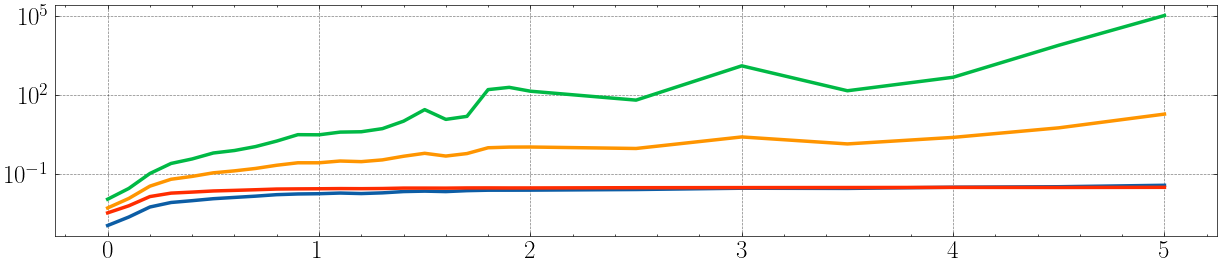

In [121]:
ens = 25
fig, axs = plt.subplots(1,1, figsize=(15,3))
for measure in measures:
    axs.plot(df.columns.values,df.loc[(ens, measure)].values, label = measure, lw = 2.5)
    
axs.set_yscale("log")
axs.xaxis.set_tick_params(labelsize=ticksize)
axs.yaxis.set_tick_params(labelsize=ticksize)

# Only include legend for yacht plot
if experiment == "yacht":
    axs.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
            fancybox=True, shadow=True, ncol=4, fontsize = legendsize)


plt.savefig(f"../../plots/robustness_{experiment}.pdf", bbox_inches = "tight")